## 14 + complex curve + tidy up

In [188]:
# %%
import torch
from torch import nn
import pdb
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import random
%matplotlib inline

from scipy.stats import norm

def normal_distribution(n, mean, var=0.05):
  x = norm.pdf(np.arange(0, 1, 1.0 / n), mean, var)
  x = x / np.sum(x)
  return torch.tensor(x).float()

def imshow(title, image, vmin=None, vmax=None, show_precision=False):
  t = "{2} [{0}, {1}]".format(np.amin(image), np.amax(image), title)

  if show_precision:
    row_count = image.shape[0]
    print(row_count)
    fig, axes = plt.subplots(2, figsize=(15,2), sharex=True, gridspec_kw={'wspace':0.0, 'hspace':0.0, 'height_ratios':[row_count, 1]})
    axes[0].set_title(t)
    axes[0].imshow(image, cmap='gray', vmin=vmin, vmax=vmax)
    axes[0].set_aspect("auto")
    axes[1].imshow([precision(image)], cmap='gray', vmin=0, vmax=2)
    axes[1].set_aspect("auto")
    fig.tight_layout()

  else:
    plt.figure(figsize=figsize)
    plt.title(t)
    plt.imshow(image, cmap='gray', vmin=vmin, vmax=vmax)

  plt.show()
    
def plot_errors(e):
    imshow('prediction errors', e, vmin=None, vmax=None)

    abs_errors = np.abs(e)
    imshow('abs_errors', abs_errors, vmin=None, vmax=None)

    positive_errors = errors.copy()
    positive_errors[positive_errors<0] = 0
    imshow('positive_errors', positive_errors, vmin=None, vmax=None)

    negative_errors = errors.copy()
    negative_errors[negative_errors>0] = 0
    negative_errors = negative_errors * -1
    imshow('negative_errors', negative_errors, vmin=None, vmax=None)

def sigmoid_array(x):                                        
    return 1 / (1 + np.exp(-x))

# signal is t_steps X quantization
# def precision(signal):
#     normalized = sigmoid_array(signal)
#     return np.max(normalized, axis=0) * 4 - 2

# def entropy(data, q=quantization):
#     data = (data - np.min(data, axis=0)) / 2.0 # -1 to 1 ==> 0 to 1
#     data[data == 0] = 0.01
#     #data = data.transpose()
#     data = np.log(data.transpose()) * np.arange(0, 1, 1.0 / q)
#     data = -np.sum(data, axis=1)
#     return data

def precision(data):
    optimal_acceleration = 1.5
    velocity = data[1:]-data[:-1]
    acceleration = velocity[1:]-velocity[:-1]
    p = np.sum(np.abs(acceleration), axis=0)
    p[p > optimal_acceleration*2] = optimal_acceleration * 2
    p = optimal_acceleration - np.abs(optimal_acceleration - p) + 0.1
    return p


def precision_weighted_difference(a, b):
    assert len(a.shape) == 2, "Must be 2D image"
    assert a.shape == b.shape, "Shapes must be the same {0}, {1}".format(a.shape, b.shape)
    pa = precision(a)
    pb = precision(b)
    diff = (a * pa - b * pb) / (pa + pb)
    return diff

figsize=(15,5)
quantization = 20

## Training pattern: sin() with a bit of noise, normal distribution around mean

In [132]:
def create_pattern(pattern_length=200, var=0.05):
    pattern_floats = torch.tensor((np.sin(np.arange(pattern_length) * 0.30) + 1.2 + np.random.sample(int(pattern_length)) * 0) / 2.5).float()
    pattern = torch.stack([normal_distribution(quantization, val, var=var) for val in pattern_floats])
    pattern = pattern / pattern.max().item() # normailze to probability distribution, i.e. sum = 1.0
    pattern[int(pattern_length*0.4):int(pattern_length*0.6), :] = 0
    pattern = pattern
    imshow('pattern', pattern.t().numpy())
    imshow('', [entropy(pattern.t().numpy())])

    return pattern

In [241]:
class Region(object):
    def __init__(self, region_name, t_sample=10):
        super().__init__()
        self.region_name = region_name
        self.t_sample = t_sample
        self.rnn = None
#         self.output = None
#         self.predictions = None
#         self.input = None
#         self.target = None

    def combine(self, mu, mu_bar):
        return (mu[1:] + mu_bar[:-1]) / 2
        
    def train_pattern(self, pattern, num_layers=10, learning_rate=0.005, epochs=2001, verbose=True):
        (pattern_length, quantization) = pattern.shape
        t_sample = self.t_sample

        batch_size = pattern_length - t_sample - 1
        (input, target) = self.prepare_input_and_target(pattern, batch_size)

        self.train(input, target, num_layers=num_layers, learning_rate=learning_rate, epochs=epochs, verbose=verbose)

    def train_patterns(self, input_pattern, target_pattern, num_layers=10, learning_rate=0.005, epochs=2001, verbose=True):
        assert input_pattern.shape ==  target_pattern.shape

        (pattern_length, quantization) = input_pattern.shape
        t_sample = self.t_sample

        batch_size = pattern_length - t_sample - 1
        
        input  = torch.stack([input_pattern [i:i+t_sample] for i in np.arange(batch_size)])
        target = torch.stack([target_pattern[i:i+t_sample] for i in np.arange(batch_size)])

        self.train(input, target, num_layers=num_layers, learning_rate=learning_rate, epochs=epochs, verbose=verbose)

    def train(self, input, target, num_layers=10, learning_rate=0.005, epochs=2001, verbose=True):
        (batch_size, t_sample, quantization) = input.shape

        # %%
        self.rnn = rnn = nn.RNN (
          input_size=quantization,
          hidden_size=quantization,
          num_layers=num_layers,
          nonlinearity='tanh',
          batch_first=True
        )

        for name, param in rnn.named_parameters():
          if 'bias' in name:
             nn.init.constant_(param, 0.0)
          elif 'weight' in name:
            nn.init.xavier_normal_(param)

        optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
        epoch = 0
        losses = []
        while epoch < epochs:
            scale = 1 #random.random()

            # get predictions
            rnn.zero_grad()
            state = torch.zeros(num_layers, batch_size, quantization)
            out, state = rnn(input * scale, state)

            # use predictions (mu_bar) and input (mu) for training
            combined_input = self.combine(input * scale, out.detach())

            if verbose and epoch % int(epochs / 4) == 0:
                i = 1
                print('epoch ', epoch)
                imshow('input(t=1)', input[i+1].detach().t().numpy())
                imshow('prediction from (t=0)', out[i].detach().t().numpy())
                imshow('combined_input(t=1)', combined_input[i].t().numpy()) # 0th entry is for t=1
                imshow('target(t=1)', target[i+1].detach().t().numpy())

            # train with mu_bar + mu
            rnn.zero_grad()
            state = torch.zeros(num_layers, batch_size-1, quantization)
            out, state = rnn(combined_input, state)

            loss = torch.nn.functional.mse_loss(out, target[1:] * scale)
            loss.backward()
            optimizer.step()
            losses.append(loss)

            epoch += 1

        plt.figure(figsize=figsize)
        plt.title(self.region_name)
        plt.plot(losses, label='loss')
        plt.legend()
        plt.show()
        
    def predict(self, pattern, scale=1.0):
        (pattern_length, quantization) = pattern.shape
        t_sample = self.t_sample

        batch_size = pattern_length - t_sample - 1
        (input, target) = self.prepare_input_and_target(pattern, batch_size)

        self.rnn.zero_grad()
        state = torch.zeros(self.rnn.num_layers, batch_size, quantization)
        out, state = self.rnn(input * scale, state)
        
        predictions = out[:, -1].detach().t().numpy()
        target_predictions = (target * scale)[:, -1].detach().t().numpy()
        return (predictions, target_predictions)

    def prepare_input_and_target(self, pattern, batch_size):
        t_sample = self.t_sample
        input = torch.stack([pattern[i:i+t_sample] for i in np.arange(batch_size)])
        target = torch.stack([pattern[i+1:i+t_sample+1] for i in np.arange(batch_size)])

        return (input, target)


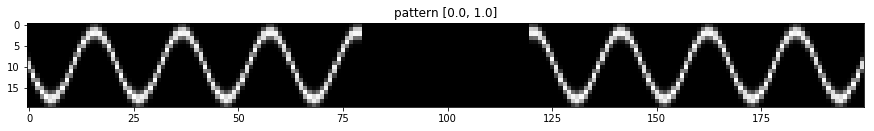

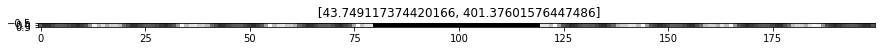

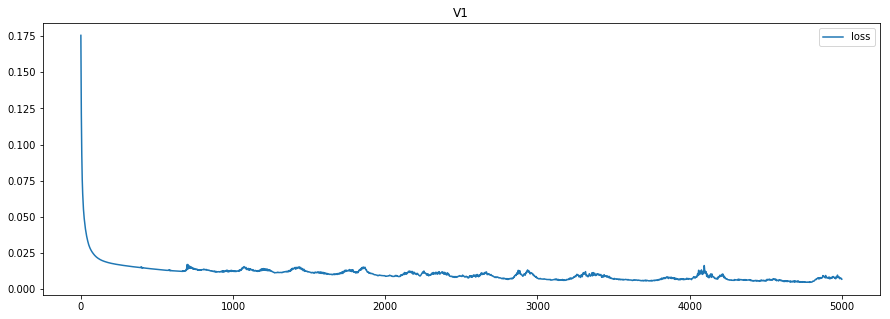

In [243]:
v1 = Region("V1", t_sample=4)
pattern = create_pattern()
v1.train_pattern(pattern, epochs=2001, verbose=False, num_layers=2)

20


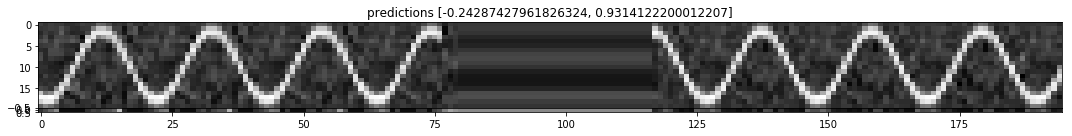

20


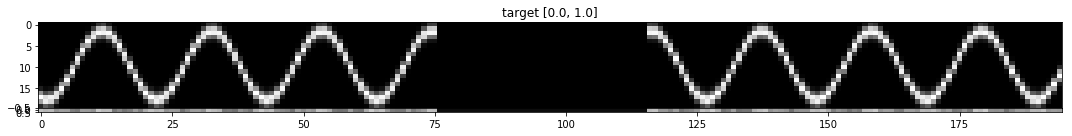

20


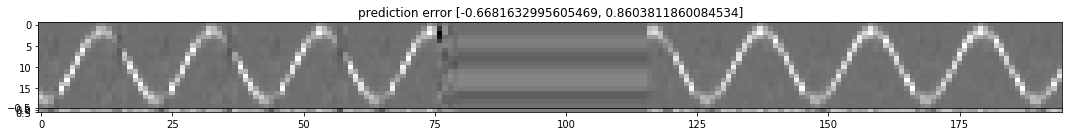

20


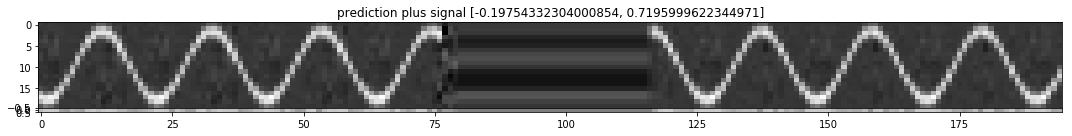

In [252]:
(predictions, target_predictions) = v1.predict(pattern)

prediction_error = precision_weighted_difference(target_predictions, predictions)
prediction_plus_signal = precision_weighted_difference(0.5 * target_predictions, -1 * predictions)

imshow("predictions", predictions, show_precision=True)
imshow("target", target_predictions, show_precision=True)
imshow("prediction error", prediction_error, show_precision=True)
imshow("prediction plus signal", prediction_plus_signal, show_precision=True)

prediction_error = prediction_plus_signal

20


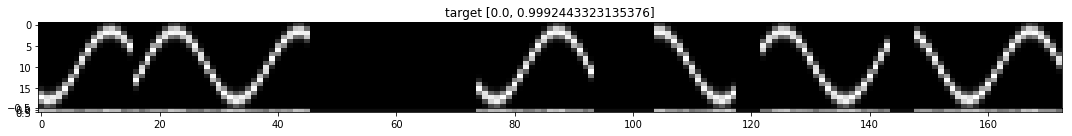

20


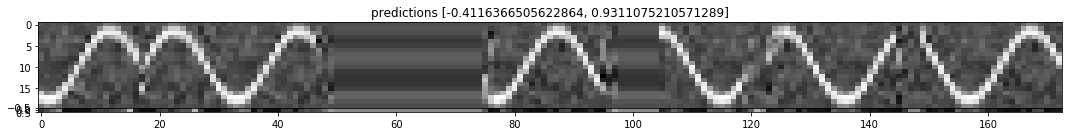

20


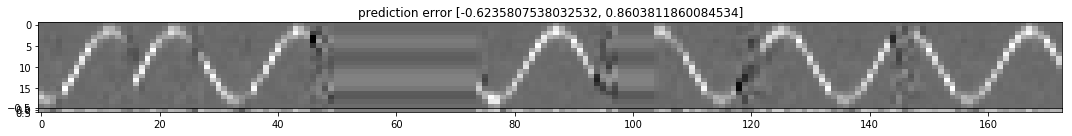

In [247]:
# %%
pattern_length = pattern.shape[0]
test_pattern = torch.cat([pattern[0:int(pattern_length*0.10)], pattern[int(pattern_length*0.15):int(pattern_length*0.30)], pattern[int(pattern_length*0.45):int(pattern_length*0.59)], pattern[int(pattern_length*0.85):int(pattern_length*0.95)], pattern[int(pattern_length*0.55):int(pattern_length*0.95)]]) # * 0.7
# blank out parts of the signal to observe illusory contours
test_pattern[122:126, :] = 0
test_pattern[148:152, :] = 0

#imshow('test_pattern', test_pattern.t().numpy())

(test_predictions, test_target_predictions) = v1.predict(test_pattern, scale=1.0)
test_prediction_error = precision_weighted_difference(test_target_predictions, test_predictions)
imshow("target", test_target_predictions, show_precision=True)
imshow("predictions", test_predictions, show_precision=True)
imshow("prediction error", test_prediction_error, show_precision=True)

20


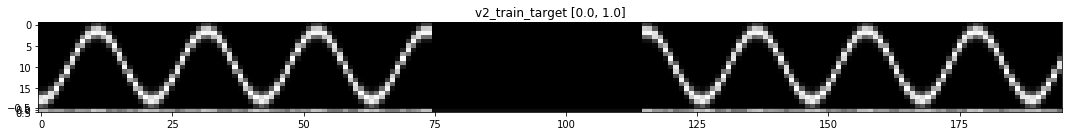

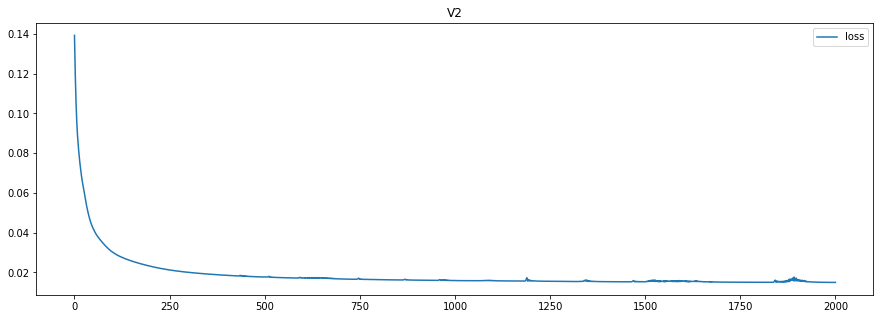

In [248]:
v2 = Region("V2", t_sample=4)
v2_train_target = pattern[(v1.t_sample+1):]
imshow("v2_train_target", v2_train_target.t().numpy(), show_precision=True)

v2.train_patterns(torch.tensor(prediction_error).t(), v2_train_target, epochs=2001, verbose=False, num_layers=1)

20


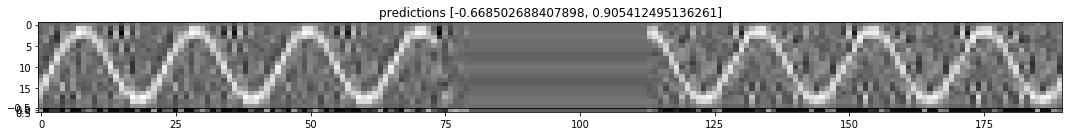

20


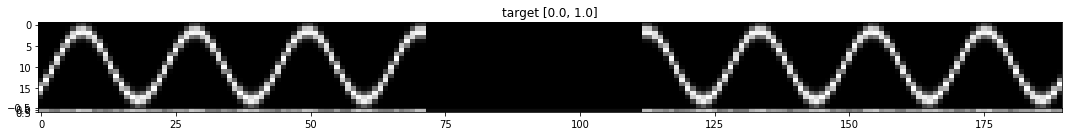

20


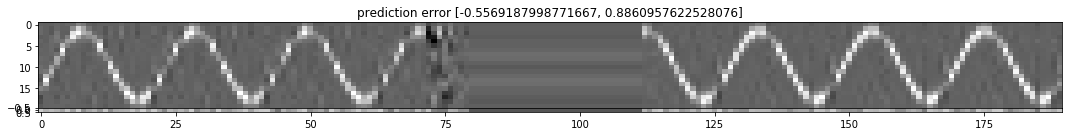

AssertionError: Shapes must be the same (20, 163), (20, 190)

In [251]:
v2_predictions_target = v2_train_target[(v2.t_sample-1):-2].t().numpy()
(v2_predictions, _) = v2.predict(torch.tensor(prediction_error).t())
v2_prediction_error = precision_weighted_difference(v2_predictions_target, v2_predictions)

imshow("predictions", v2_predictions, show_precision=True)
imshow("target", v2_predictions_target, show_precision=True)
imshow("prediction error", v2_prediction_error, show_precision=True)

combined_prediction = precision_weighted_difference(predictions[:, v1.t_sample+1:], -1 * v2_predictions)
imshow("v1+v2 predictions", combined_prediction, show_precision=True)

combined_error = precision_weighted_difference(v2_predictions_target[:, 1:], combined_prediction[:, :-1])
imshow("combined error", combined_error, show_precision=True)


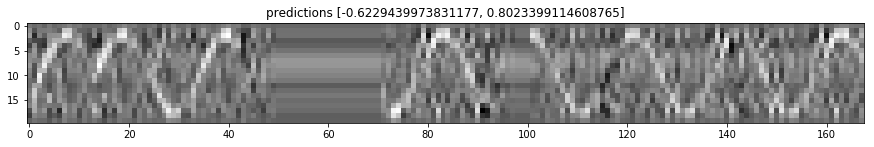

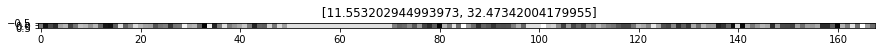

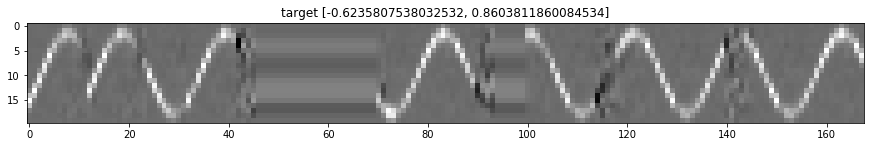

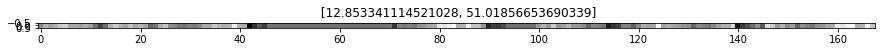

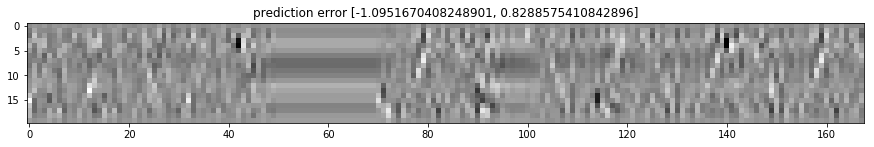

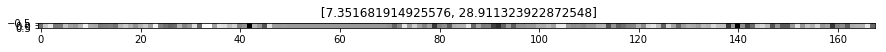

In [250]:
(predictions, target_predictions) = v2.predict(torch.tensor(test_prediction_error).t())
imshow("predictions", predictions)
imshow('', [entropy(predictions)])
imshow("target", target_predictions)
imshow('', [entropy(target_predictions)])
imshow("prediction error", target_predictions - predictions)
imshow('', [entropy(target_predictions - predictions)])

## Next steps
- train g(hidden state, mu-(mu_bar + mu_hat))
- use 2D sample instaead of single point
- use multiple layers

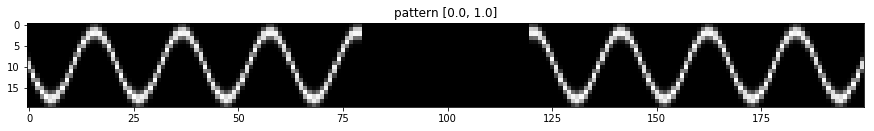

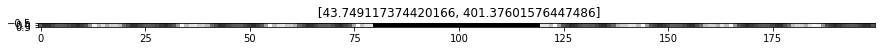

torch.Size([20])

In [82]:
pattern = create_pattern()

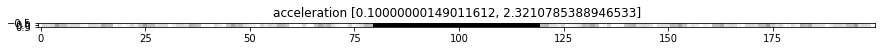

In [95]:

imshow('acceleration', [acceleration])